In [ ]:
uname = "jdowner212"
!git config --global user.email 'jdowner@hawk.iit.edu'
!git config --global user.name 'jdowner212'

#Make a clone of github REPO
!git clone https://jdowner212:<PERSONAL_ACCESS_TOKEN>@github.com/<U_NAME>/<REPO_NAME>

#Copy file from either google drive after mounting using file browser
!cp <PATH_OF_FILE_TO_COPY> /content/<REPO_NAME>

In [2]:
### SET WORKING DIRECTORY
this_repo = '/content/drive/MyDrive/PointNet_reimplementation'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys

Mounted at /content/drive


In [4]:
os.chdir(this_repo)

In [5]:
## IMPORTING & INSTALLING LIBRARIES

import plotly
import plotly.express as px
from   plotly.colors import n_colors
from   plotly.subplots import make_subplots
import math
import h5py
import socket
import shutil
import subprocess
import pandas as pd
import numpy as np
from   numpy.random import uniform
import matplotlib.pyplot as plt
import threadpoolctl
import scipy
import joblib
import cmake
import sklearn
import seaborn as sns
import tensorflow
import time

!pip install open3d path trimesh pyransac3d # May throw errors -- wasn't a problem for me

import path
import open3d as o3d
from open3d import utility as utility
V3dV =  o3d.utility.Vector3dVector
import torch

## IMPORTING ORIGINAL MODULES

sys.path.append(this_repo)
sys.path.append(os.path.join(this_repo, 'sem_seg'))
sys.path.append(os.path.join(this_repo, 'utils'))

import MyCloud_utils
from   MyCloud_utils import *
import provider as provider
import tf_util as tf_util
from   model import *

     |████████████████████████████████| 408.6 MB 22 kB/s 
     |████████████████████████████████| 645 kB 84.7 MB/s 
     |████████████████████████████████| 1.1 MB 81.8 MB/s 
     |████████████████████████████████| 8.7 MB 73.6 MB/s 
     |████████████████████████████████| 596 kB 82.0 MB/s 
     |████████████████████████████████| 4.3 MB 40.6 MB/s 
     |████████████████████████████████| 342 kB 75.9 MB/s 
     |████████████████████████████████| 428 kB 87.2 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 1.1 MB 70.6 MB/s 
     |████████████████████████████████| 561 kB 75.9 MB/s 
     |████████████████████████████████| 79 kB 7.6 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 130 kB 76.4 MB/s 
     |████████████████████████████████| 133 kB 65.1 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninst

In [49]:
######## TRAIN ########

BASE_DIR = os.path.join(this_repo,'sem_seg')
ROOT_DIR = os.path.dirname(BASE_DIR)
os.chdir(BASE_DIR)

FLAGS = {'gpu': 0, 'log_dir': 'log5', 'num_point' : 4096, 'max_epoch': 100, 'batch_size': 36, 'learning_rate': 0.001, 'momentum': 0.9, 'optimizer': 'momentum', 'decay_step': 200000, 'decay_rate': 0.7, 'test_area': 5}

BATCH_SIZE = FLAGS['batch_size']
NUM_POINT = FLAGS['num_point']
MAX_EPOCH = FLAGS['max_epoch']
NUM_POINT = FLAGS['num_point']
BASE_LEARNING_RATE = FLAGS['learning_rate']
GPU_INDEX = FLAGS['gpu']
MOMENTUM = FLAGS['momentum']
OPTIMIZER = FLAGS['optimizer']
DECAY_STEP = FLAGS['decay_step']
DECAY_RATE = FLAGS['decay_rate']
LOG_DIR = FLAGS['log_dir']

if not os.path.exists(LOG_DIR): os.mkdir(LOG_DIR)
os.system('cp model.py %s' % (LOG_DIR)) # bkp of model def
os.system('cp train.py %s' % (LOG_DIR)) # bkp of train procedure
LOG_FOUT = open(os.path.join(LOG_DIR, 'log_train.txt'), 'w')
LOG_FOUT.write(str(FLAGS)+'\n')

MAX_NUM_POINT = NUM_POINT
NUM_CLASSES = 13

BN_INIT_DECAY = 0.5
BN_DECAY_DECAY_RATE = 0.5
BN_DECAY_DECAY_STEP = float(DECAY_STEP)
BN_DECAY_CLIP = 0.99

HOSTNAME = socket.gethostname()


ALL_FILES = provider.getDataFiles(ROOT_DIR + '/data/indoor3d_sem_seg_hdf5_data/all_files.txt')
room_filelist = [line.rstrip() for line in open(ROOT_DIR + '/data/indoor3d_sem_seg_hdf5_data/room_filelist.txt')]

# Load ALL data
data_batch_list = []
label_batch_list = []
for h5_filename in ALL_FILES:
    data_batch, label_batch = provider.loadDataFile(ROOT_DIR + '/data/' + h5_filename)
    data_batch_list.append(data_batch)
    label_batch_list.append(label_batch)
data_batches = np.concatenate(data_batch_list, 0)
label_batches = np.concatenate(label_batch_list, 0)
print(data_batches.shape)
print(label_batches.shape)

test_area = 'Area_'+str(FLAGS['test_area'])
train_idxs = []
test_idxs = []
for i,room_name in enumerate(room_filelist):
    if test_area in room_name:
        test_idxs.append(i)
    else:
        train_idxs.append(i)

train_data = data_batches[train_idxs,...]
train_label = label_batches[train_idxs]
test_data = data_batches[test_idxs,...]
test_label = label_batches[test_idxs]
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

def log_string(out_str):
    LOG_FOUT.write(out_str+'\n')
    LOG_FOUT.flush()
    print(out_str)

def get_learning_rate(batch):
    learning_rate = tf.compat.v1.train.exponential_decay(
                        BASE_LEARNING_RATE,  # Base learning rate.
                        batch * BATCH_SIZE,  # Current index into the dataset.
                        DECAY_STEP,          # Decay step.
                        DECAY_RATE,          # Decay rate.
                        staircase=True)
    learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!!
    return learning_rate        

def get_bn_decay(batch):
    bn_momentum = tf.compat.v1.train.exponential_decay(
                      BN_INIT_DECAY, batch*BATCH_SIZE, BN_DECAY_DECAY_STEP,BN_DECAY_DECAY_RATE, staircase=True)
    bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
    return bn_decay

def train():
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            pointclouds_pl, labels_pl = placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.compat.v1.placeholder(tf.bool, shape=())
            
            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.compat.v1.summary.scalar('bn_decay', bn_decay)

            # Get model and loss 
            pred = get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = get_loss(pred, labels_pl)
            tf.compat.v1.summary.scalar('loss', loss)

            correct = tf.equal(tf.argmax(input=pred, axis=2), tf.cast(labels_pl, dtype=tf.int64))
            accuracy = tf.reduce_sum(input_tensor=tf.cast(correct, tf.float32)) / float(BATCH_SIZE*NUM_POINT)
            tf.compat.v1.summary.scalar('accuracy', accuracy)

            # Get training operator
            learning_rate = get_learning_rate(batch)
            tf.compat.v1.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.compat.v1.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)
            
            # Add ops to save and restore all the variables.
            saver = tf.compat.v1.train.Saver()
            
        # Create a session
        config = tf.compat.v1.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = True
        sess = tf.compat.v1.Session(config=config)

        # Add summary writers
        merged = tf.compat.v1.summary.merge_all()
        train_writer = tf.compat.v1.summary.FileWriter(os.path.join(LOG_DIR, 'train'),
                                  sess.graph)
        test_writer = tf.compat.v1.summary.FileWriter(os.path.join(LOG_DIR, 'test'))

        # Init variables
        init = tf.compat.v1.global_variables_initializer()
        sess.run(init, {is_training_pl:True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'labels_pl': labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}

        for epoch in range(MAX_EPOCH):
            now = time.time()
            log_string('**** EPOCH %03d ****' % (epoch))
            sys.stdout.flush()
             
            train_one_epoch(sess, ops, train_writer)
            eval_one_epoch(sess, ops, test_writer)
            
            # Save the variables to disk.
            if epoch % 10 == 0:
                save_path = saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)
            print('Total time spent int epoch: {}'.format(np.round(time.time()-now,3)))


def train_one_epoch(sess, ops, train_writer):
    """ ops: dict mapping from string to tf ops """
    is_training = True
    
    log_string('----')
    current_data, current_label, _ = provider.shuffle_data(train_data[:,0:NUM_POINT,:], train_label) 
    
    file_size = current_data.shape[0]
    num_batches = file_size // BATCH_SIZE
    
    total_correct = 0
    total_seen = 0
    loss_sum = 0
    
    for batch_idx in range(num_batches):
        if batch_idx % 100 == 0:
            print('Current batch/total batch num: %d/%d'%(batch_idx,num_batches))
        start_idx = batch_idx * BATCH_SIZE
        end_idx = (batch_idx+1) * BATCH_SIZE
        
        feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                     ops['labels_pl']: current_label[start_idx:end_idx],
                     ops['is_training_pl']: is_training,}
        summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'], ops['train_op'], ops['loss'], ops['pred']],
                                         feed_dict=feed_dict)
        train_writer.add_summary(summary, step)
        pred_val = np.argmax(pred_val, 2)
        correct = np.sum(pred_val == current_label[start_idx:end_idx])
        total_correct += correct
        total_seen += (BATCH_SIZE*NUM_POINT)
        loss_sum += loss_val
    
    log_string('mean loss:  %f' % (loss_sum / float(num_batches)))
    log_string('accuracy:   %f' % (total_correct / float(total_seen)))

        
def eval_one_epoch(sess, ops, test_writer):
    """ ops: dict mapping from string to tf ops """
    is_training = False
    total_correct = 0
    total_seen = 0
    loss_sum = 0
    total_seen_class = [0 for _ in range(NUM_CLASSES)]
    total_correct_class = [0 for _ in range(NUM_CLASSES)]
    
    log_string('----')
    current_data = test_data[:,0:NUM_POINT,:]
    current_label = np.squeeze(test_label)
    
    file_size = current_data.shape[0]
    num_batches = file_size // BATCH_SIZE
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * BATCH_SIZE
        end_idx = (batch_idx+1) * BATCH_SIZE

        feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                     ops['labels_pl']: current_label[start_idx:end_idx],
                     ops['is_training_pl']: is_training}
        summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'], ops['loss'], ops['pred']],
                                      feed_dict=feed_dict)
        test_writer.add_summary(summary, step)
        pred_val = np.argmax(pred_val, 2)
        correct = np.sum(pred_val == current_label[start_idx:end_idx])
        total_correct += correct
        total_seen += (BATCH_SIZE*NUM_POINT)
        loss_sum += (loss_val*BATCH_SIZE)
        for i in range(start_idx, end_idx):
            for j in range(NUM_POINT):
                l = current_label[i, j]
                total_seen_class[l] += 1
                total_correct_class[l] += (pred_val[i-start_idx, j] == l)
            
    log_string('eval mean loss:     %f' % (loss_sum / float(total_seen/NUM_POINT)))
    log_string('eval accuracy:      %f' % (total_correct / float(total_seen)))
    log_string('eval avg class acc: %f' % (np.mean(np.array(total_correct_class)/np.array(total_seen_class,dtype=np.float))))


if __name__ == "__main__":
    train()
    LOG_FOUT.close()

####### END OF TRAIN ########

FileNotFoundError: ignored

In [6]:
def plot_from_file(filename,title):
  results = {}
  with open (filename) as output:
    lines = output.readlines()
    for l in lines:
      if l[:4] in ['eval','mean','accu']:
        key, val = l.split(': ')
        if key in list(results.keys()):
          results[key] = results[key] + [float(val)]
        else:
          results[key] = [float(val)]

  import matplotlib.pyplot as plt
  keys = list(results.keys())
  for k in keys:
    plt.plot(range(len(results[k])),results[k],label=k)
  plt.title(title)
  plt.legend()
  plt.show()

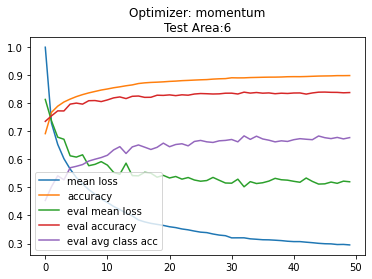

In [7]:
f6_momentum = os.path.join(this_repo, 'sem_seg/log6/log_train.txt')
plot_from_file(f6_momentum,'Optimizer: momentum\nTest Area:6')

In [ ]:
######################################
######## EVALUATE ON TEST SET ########
######################################

def write_data_label_stanford(Area=6,repo_path = this_repo):
  stanford_3d = os.path.join(repo_path,'data/stanford_indoor3d')
  dirs = [os.path.join('data/stanford_indoor3d',d) for d in os.listdir(stanford_3d) if 'Area_{}'.format(str(Area)) in d]
  meta = os.path.join(repo_path,'/sem_seg/meta')
  with open(os.path.join(meta,'area{}_data_label.txt').format(str(Area)),'w') as out:
    out.write('\n'.join(dirs))
  out.close()

############
### RUN: ###
############

#os.chdir(os.path.join(this_repo,'sem_seg'))
#write_data_label_stanford(6,this_repo)
#!python batch_inference.py --model_path log6/model.ckpt --dump_dir log6/dump --output_filelist log6/output_filelist.txt --room_data_filelist meta/area6_data_label.txt --visu

In [43]:
#############################
### SEGMENT YOUR OWN DATA ###
#############################

#1.  Save pointclouds in xyzrgb (.txt) format and put in 'pointcloud_files_to_segment' folder.

#2.  There's a little glitch in segment_my_data.py that I'm working on.
#    The workaround is to run these 3 commands all at once (commented out so you can plug in your own filepaths):

#!python [path to 'segment_my_data.py'] --file_src [path to pointcloud .txt file in 'pointcloud_files_to_segment'] --log_src [path to 'sem_seg/log6'] --fixed=False
#!python [path to 'sem_seg/collect_indoor3d_data_TEST_copy.py']
#!python [path to 'segment_my_data.py'] --file_src [path to pointcloud .txt file in 'pointcloud_files_to_segment'] --log_src [path to 'sem_seg/log6'] --fixed=True


#!python /content/drive/MyDrive/PointNet_reimplementation/sem_seg/segment_my_data.py --file_src /content/drive/MyDrive/PointNet_reimplementation/pointcloud_files_to_segment/room_234.txt --log_src /content/drive/MyDrive/PointNet_reimplementation/sem_seg/log6 --fixed=False
#!python /content/drive/MyDrive/PointNet_reimplementation/sem_seg/collect_indoor3d_data_TEST_copy.py
#!python /content/drive/MyDrive/PointNet_reimplementation/sem_seg/segment_my_data.py --file_src /content/drive/MyDrive/PointNet_reimplementation/pointcloud_files_to_segment/room_234.txt --log_src /content/drive/MyDrive/PointNet_reimplementation/sem_seg/log6 --fixed=True


In [44]:
the_colors = ['red', 'sienna', 'chartreuse', 'green', 
              'blue', 'plum', 'gold', 'black', 'aqua', 'orange','lightgray','yellowgreen','peachpuff']

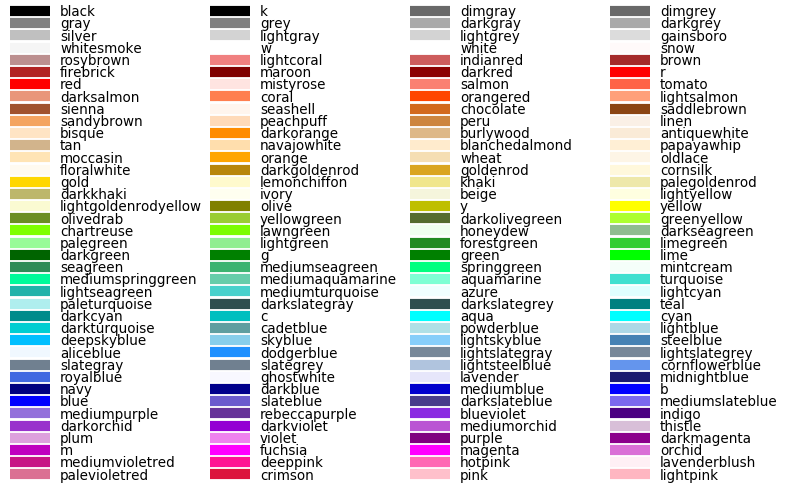

In [47]:
pred_txt_file = '/content/drive/MyDrive/PointNet_reimplementation/sem_seg/log_room_234_room_234/dump/room_234_room_234_pred.txt'
MyCloud_utils.color_code_file(pred_txt_file)
#segment_original_colors(pred_txt_file)

Output hidden; open in https://colab.research.google.com to view.